In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install hanja

In [3]:
import hanja
from hanja import hangul

In [4]:
import gc
import pandas as pd
import numpy as np
import re
import tensorflow
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.regularizers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
gc.collect()

8

In [7]:
cd /content/gdrive/My Drive/dacon/NH

/content/gdrive/My Drive/dacon/NH


In [8]:
train = pd.read_csv('news_train.csv')
test = pd.read_csv("news_test.csv")
submission = pd.read_csv("sample_submission.csv")

In [9]:
train.head()

,n_id,date,title,content,ord,info
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0


In [10]:
test.head()

,n_id,date,title,content,ord,id
0,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",마이크로 LED TV 장비 양산 돌입- 전방업체 투자 확대로 본업도 호조연일 '신고가',1,NEWS00237_1
1,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",[이데일리 김대웅 기자] 반도체 장비 업체 코세스(089890)의 기술력이 마이크로...,2,NEWS00237_2
2,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",최근 대형 업체들과 거래를 맺고 관련 장비들의 양산에 돌입하면서 주가도 연일 신고가...,3,NEWS00237_3
3,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",TV를 필두로 올해부터 마이크로 LED의 시대가 본격적으로 개화할 것으로 예상되면서...,4,NEWS00237_4
4,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대","코세스는 반도체 장비를 제조, 판매하는 업체로 지난 2006년 11월 코스닥 시장에...",5,NEWS00237_5


In [11]:
submission.head()

,id,info
0,NEWS00237_1,0
1,NEWS00237_2,0
2,NEWS00237_3,0
3,NEWS00237_4,0
4,NEWS00237_5,0


### Preprocessing


In [16]:
train['length_text'] = train.content.apply(lambda x : len(x))
test['length_text'] = test.content.apply(lambda x : len(x))

In [ ]:
train.sample(10)

,n_id,date,title,content,ord,info,length_text
64992,NEWS00705,20200519,"백악관 백신개발 총책, “모더나 스톡옵션 보유, 이해상충” 지적에 처분",정치테마 매집+거래량+핵심인맥 당장 줄상한가 가도 책임안집니다,84,1,34
106154,NEWS05798,20200331,"‘꽃 보다 코로나’…강북구, 우이천변 벚꽃길 통제",통제구역은 신창교에서 쌍한교에 이르는 벚꽃길 조성구간과 번2동 주민센터 주변 지점부...,10,0,82
23146,NEWS02300,20200315,정의당 '대리게임' 논란 류호정 재신임 … '음주운전' 신장식은 자진 사퇴,1번인 류호정 당 IT산업노동특별위원장과 6번인 신장식 전 사무총장은 비례대표 후보...,6,0,126
106040,NEWS03010,20200508,"“용산, 진짜 로또가 나타났다”…부풀어 오른 청약 기대감",저평가+실적+재료 받쳐주는 바이오 대장株. 2020년 한 종목으로 끝,84,1,38
32158,NEWS05895,20200513,"부산도 이태원 클럽발 '2차 감염' 나왔다…""1살 조카 확진""",13일 부산시 코로나19 현안브리핑에 따르면 전날까지 부산 이태원 클럽 방문 확진자...,5,0,60
84263,NEWS07042,20200629,"항바이러스제·AI융복합기술, 기술사업화 날개 단다","인공지능산업 집중 육성전략과 발맞춰 AI 기반 정밀의료, 스마트 공장, 관제시스템,...",11,0,119
91428,NEWS07176,20200410,인순이 ‘범국민 코로나 극복 캠페인송’ 재능기부,업계 최저금리 2.29%. 100%한종목 투자가능+신용/ 미수 대환가능,24,1,39
106349,NEWS00650,20200224,"""서울은 사실상 거래허가제""…3억원 이상 주택 매입시 자금출처 소명",10%수익을 40%로 만들어 준다고.. 영웅스탁론이라면 가능~.효과적인 레버리지를 ...,121,1,61
61149,NEWS07851,20200420,[인터뷰]종로 장수카페의 변신…커피 넘어 ‘공간’을 팔다,지난달 23일 광화문점 문을 연 것이다,181,0,21
40240,NEWS03397,20200217,호주정부도 日 크루즈선 탑승 자국민 200여명 대피 계획 밝혀,"모리슨 총리는 ""탑승자와 가족들이 이런 방침에 실망감을 느낄 것이라는 점을 충분히 ...",8,0,106


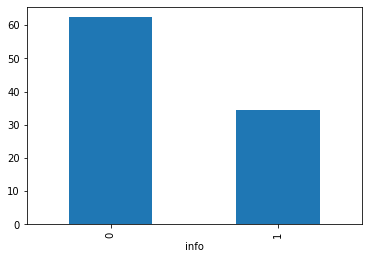

In [ ]:
train.groupby('info').length_text.mean().plot(kind = 'bar')
plt.show()

In [17]:
train['text'] = train.title + ' ' + train.content
test['text'] = test.title + ' ' + test.content

In [18]:
train.text = train.text.apply(lambda x : hanja.translate(x, 'substitution'))
test.text = test.text.apply(lambda x : hanja.translate(x, 'substitution'))

In [19]:
train_text = list(train['text'])

train_clear_text = []

for i in tqdm(range(len(train_text))):
  train_clear_text.append(str(train_text[i]).replace('\\n', ''))
train['clear_text'] = train_clear_text
train.head()

100%|██████████| 118745/118745 [00:00<00:00, 1357487.41it/s]


,n_id,date,title,content,ord,info,length_text,text,clear_text
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0,42,[마감]코스닥 기관 678억 순매도 [이데일리 MARKETPOINT]15:32 현재...,[마감]코스닥 기관 678억 순매도 [이데일리 MARKETPOINT]15:32 현재...
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1,37,"[마감]코스닥 기관 678억 순매도 ""실적기반"" 저가에 매집해야 할 8월 급등유망주...","[마감]코스닥 기관 678억 순매도 ""실적기반"" 저가에 매집해야 할 8월 급등유망주..."
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1,33,"[마감]코스닥 기관 678억 순매도 하이스탁론, 선취수수료 없는 월 0.4% 최저금...","[마감]코스닥 기관 678억 순매도 하이스탁론, 선취수수료 없는 월 0.4% 최저금..."
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0,32,[마감]코스닥 기관 678억 순매도 종합 경제정보 미디어 이데일리 - 무단전재 & ...,[마감]코스닥 기관 678억 순매도 종합 경제정보 미디어 이데일리 - 무단전재 & ...
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0,20,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참 전국적인 소비 붐 조성에 기여할 예정","롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참 전국적인 소비 붐 조성에 기여할 예정"


In [20]:
train_clear_text = list(train['clear_text'])

train_clear_text2 = []

for text in train_clear_text:
  temp = re.sub('[-=+,#:;//●<>▲\?:^$.☆!★()Ⅰ@*\"※~>`\'…》]', ' ', text)
  train_clear_text2.append(temp)
train['clear_text'] = train_clear_text2
train.head()

,n_id,date,title,content,ord,info,length_text,text,clear_text
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0,42,[마감]코스닥 기관 678억 순매도 [이데일리 MARKETPOINT]15:32 현재...,[마감]코스닥 기관 678억 순매도 [이데일리 MARKETPOINT]15 32 현재...
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1,37,"[마감]코스닥 기관 678억 순매도 ""실적기반"" 저가에 매집해야 할 8월 급등유망주...",[마감]코스닥 기관 678억 순매도 실적기반 저가에 매집해야 할 8월 급등유망주...
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1,33,"[마감]코스닥 기관 678억 순매도 하이스탁론, 선취수수료 없는 월 0.4% 최저금...",[마감]코스닥 기관 678억 순매도 하이스탁론 선취수수료 없는 월 0 4% 최저금...
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0,32,[마감]코스닥 기관 678억 순매도 종합 경제정보 미디어 이데일리 - 무단전재 & ...,[마감]코스닥 기관 678억 순매도 종합 경제정보 미디어 이데일리 무단전재 & ...
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0,20,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참 전국적인 소비 붐 조성에 기여할 예정",롯데·공영 등 7개 TV 홈쇼핑들 동행세일 동참 전국적인 소비 붐 조성에 기여할 예정


In [21]:
test_text = list(test['text'])

test_clear_text = []

for i in tqdm(range(len(test_text))):
  test_clear_text.append(str(test_text[i]).replace('\\n', ''))
test['clear_text'] = test_clear_text
test.head()

100%|██████████| 142565/142565 [00:00<00:00, 1399914.66it/s]


,n_id,date,title,content,ord,id,length_text,text,clear_text
0,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",마이크로 LED TV 장비 양산 돌입- 전방업체 투자 확대로 본업도 호조연일 '신고가',1,NEWS00237_1,48,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대 마이크로 LED T...","[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대 마이크로 LED T..."
1,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",[이데일리 김대웅 기자] 반도체 장비 업체 코세스(089890)의 기술력이 마이크로...,2,NEWS00237_2,76,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대 [이데일리 김대웅 ...","[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대 [이데일리 김대웅 ..."
2,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",최근 대형 업체들과 거래를 맺고 관련 장비들의 양산에 돌입하면서 주가도 연일 신고가...,3,NEWS00237_3,56,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대 최근 대형 업체들과...","[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대 최근 대형 업체들과..."
3,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",TV를 필두로 올해부터 마이크로 LED의 시대가 본격적으로 개화할 것으로 예상되면서...,4,NEWS00237_4,76,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대 TV를 필두로 올해...","[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대 TV를 필두로 올해..."
4,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대","코세스는 반도체 장비를 제조, 판매하는 업체로 지난 2006년 11월 코스닥 시장에...",5,NEWS00237_5,102,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대 코세스는 반도체 장...","[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대 코세스는 반도체 장..."


In [22]:
test_clear_text = list(test['clear_text'])

test_clear_text2 = []

for text in test_clear_text:
  temp = re.sub('[-=+,#:;//●<>▲\?:^$.☆!★()Ⅰ@*\"※~>`\'…》]', ' ', text)
  test_clear_text2.append(temp)
test['clear_text'] = test_clear_text2
test.head()

,n_id,date,title,content,ord,id,length_text,text,clear_text
0,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",마이크로 LED TV 장비 양산 돌입- 전방업체 투자 확대로 본업도 호조연일 '신고가',1,NEWS00237_1,48,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대 마이크로 LED T...",[주목 e스몰캡]코세스 마이크로LED 시장 개화 최대수혜 기대 마이크로 LED T...
1,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",[이데일리 김대웅 기자] 반도체 장비 업체 코세스(089890)의 기술력이 마이크로...,2,NEWS00237_2,76,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대 [이데일리 김대웅 ...",[주목 e스몰캡]코세스 마이크로LED 시장 개화 최대수혜 기대 [이데일리 김대웅 ...
2,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",최근 대형 업체들과 거래를 맺고 관련 장비들의 양산에 돌입하면서 주가도 연일 신고가...,3,NEWS00237_3,56,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대 최근 대형 업체들과...",[주목 e스몰캡]코세스 마이크로LED 시장 개화 최대수혜 기대 최근 대형 업체들과...
3,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",TV를 필두로 올해부터 마이크로 LED의 시대가 본격적으로 개화할 것으로 예상되면서...,4,NEWS00237_4,76,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대 TV를 필두로 올해...",[주목 e스몰캡]코세스 마이크로LED 시장 개화 최대수혜 기대 TV를 필두로 올해...
4,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대","코세스는 반도체 장비를 제조, 판매하는 업체로 지난 2006년 11월 코스닥 시장에...",5,NEWS00237_5,102,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대 코세스는 반도체 장...",[주목 e스몰캡]코세스 마이크로LED 시장 개화 최대수혜 기대 코세스는 반도체 장...


In [12]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

fatal: destination path 'Mecab-ko-for-Google-Colab' already exists and is not an empty directory.


In [13]:
cd Mecab-ko-for-Google-Colab/

/content/gdrive/My Drive/dacon/NH/Mecab-ko-for-Google-Colab


In [14]:
!bash install_mecab-ko_on_colab190912.sh

Installing konlpy.....
     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 460kB 41.8MB/s 
     |████████████████████████████████| 92kB 13.8MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2020-11-24 00:39:56--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c3:9b0a, 2406:da00:ff00::22c2:513, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloa

In [15]:
from konlpy.tag import Mecab
mecab = Mecab()

In [23]:
X_train = []

text = list(train['clear_text'])

for i in tqdm(range(len(text))):
  temp_X = []
  temp_X = mecab.nouns(text[i]) # 토큰화
  #temp_X = [word for word in temp_X if not word in stop_words] # 불용어 제거
  temp_X = [word for word in temp_X if len(word) > 1]
  X_train.append(temp_X)

100%|██████████| 118745/118745 [00:17<00:00, 6756.93it/s]


In [24]:
X_test = []

text = list(test['clear_text'])

for i in tqdm(range(len(text))):
  temp_X = []
  temp_X = mecab.nouns(text[i]) # 토큰화
  #temp_X = [word for word in temp_X if not word in stop_words] # 불용어 제거
  temp_X = [word for word in temp_X if len(word) > 1]
  X_test.append(temp_X)

100%|██████████| 142565/142565 [00:21<00:00, 6657.90it/s]


In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.regularizers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [27]:
threshold = 8
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 26740
등장 빈도가 7번 이하인 희귀 단어의 수: 15827
단어 집합에서 희귀 단어의 비율: 59.188481675392666
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.10706134865623


In [28]:
vocab_size = total_cnt - rare_cnt + 1 # 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거. 0번 패딩 토큰을 고려하여 +1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 10914


In [29]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
token_X_train = tokenizer.texts_to_sequences(X_train)
token_X_test = tokenizer.texts_to_sequences(X_test)

In [30]:
drop_train = [index for index, sentence in enumerate(token_X_train) if len(sentence) < 1]

In [31]:
del_X_train = np.delete(token_X_train, drop_train, axis=0)
del_y_train = train.query('index not in @drop_train')['info']
print(len(del_X_train))
print(len(del_y_train))

118580
118580


train data의 최대 길이 : 508
train data의 평균 길이 : 15.188851408331928


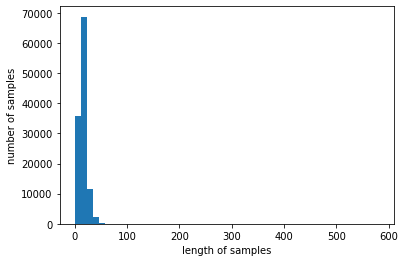

In [32]:
print('train data의 최대 길이 :',max(len(l) for l in del_X_train))
print('train data의 평균 길이 :',sum(map(len, del_X_train))/len(del_X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

test data의 최대 길이 :  317
test data의 평균 길이 :  14.472121488443868


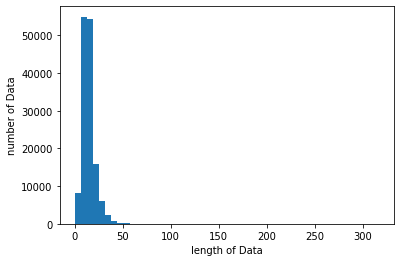

In [33]:
print("test data의 최대 길이 : ", max(len(l) for l in token_X_test))
print("test data의 평균 길이 : ", sum(map(len, token_X_test))/ len(token_X_test))
plt.hist([len(s) for s in token_X_test], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [34]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [35]:
max_len = 317
below_threshold_len(max_len, del_X_train)

전체 샘플 중 길이가 317 이하인 샘플의 비율: 99.99747006240513


In [36]:
pad_X_train = pad_sequences(del_X_train, maxlen = max_len, padding = 'post')
pad_X_test = pad_sequences(token_X_test, maxlen = max_len, padding = 'post')

In [43]:
model1 = Sequential()
model1.add(Embedding(vocab_size,64, input_length=max_len))
model1.add(Conv1D(64, 5, activation = 'relu', padding = 'same', kernel_regularizer=l2(0.01)))
model1.add(GlobalMaxPooling1D())
model1.add(Dense(1, activation = 'sigmoid'))
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 317, 64)           698496    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 317, 64)           20544     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 719,105
Trainable params: 719,105
Non-trainable params: 0
_________________________________________________________________


In [49]:
model1.compile(optimizer=RMSprop(lr = .0005), loss='binary_crossentropy', metrics=['acc'])
reLR = ReduceLROnPlateau(patience = 5, verbose=1, factor = .2)
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience = 2)
mc = ModelCheckpoint(filepath = '1123_1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True, restore_best_weights = True)

In [50]:
X_tr = pad_X_train[:110000]
X_te = pad_X_train[110000:]
y_tr = del_y_train[:110000]
y_te = del_y_train[110000:]

In [51]:

history1 = model1.fit(X_tr, y_tr, epochs=30, batch_size= 64, shuffle = True, validation_split=0.1, verbose = 1, callbacks=[es, mc, reLR])

Epoch 1/30
1545/1547 [============================>.] - ETA: 0s - loss: 0.1392 - acc: 0.9524
Epoch 00001: val_acc improved from -inf to 0.98347, saving model to 1123_1.h5
1547/1547 [==============================] - 14s 9ms/step - loss: 0.1392 - acc: 0.9523 - val_loss: 0.0832 - val_acc: 0.9835
Epoch 2/30
1544/1547 [============================>.] - ETA: 0s - loss: 0.1309 - acc: 0.9560
Epoch 00002: val_acc improved from 0.98347 to 0.98684, saving model to 1123_1.h5
1547/1547 [==============================] - 14s 9ms/step - loss: 0.1308 - acc: 0.9560 - val_loss: 0.0624 - val_acc: 0.9868
Epoch 3/30
1543/1547 [============================>.] - ETA: 0s - loss: 0.1247 - acc: 0.9585
Epoch 00003: val_acc did not improve from 0.98684
1547/1547 [==============================] - 13s 9ms/step - loss: 0.1247 - acc: 0.9585 - val_loss: 0.0923 - val_acc: 0.9744
Epoch 4/30
1543/1547 [============================>.] - ETA: 0s - loss: 0.1202 - acc: 0.9605
Epoch 00004: val_acc did not improve from 0.986

In [52]:
model = load_model('1123_1.h5')

In [53]:
from sklearn.metrics import accuracy_score

In [87]:
pred = model.predict_classes(X_te)

In [89]:
pred_list = []
for i in range(len(pred)) :
  
  pred_list.append(pred[i][0])

In [90]:
accuracy_score(y_te, pred_list)

0.9864801864801864

In [82]:
pred = model.predict_classes(pad_X_test)

In [83]:
submission['info'] = pred

In [84]:
submission.to_csv('1124.csv', index = False)